In [1]:
# Custom Imports
import polysaccharide as ps
from polysaccharide import analysis, extratypes, filetree, general, logutils, molutils
from polysaccharide import polymer

from polysaccharide.charging.residues import ChargedResidue
from polysaccharide.charging.application import CHARGER_REGISTRY, ChargingParameters

from polysaccharide import LOGGERS_MASTER
from polysaccharide.logutils import ProcessLogHandler

from polysaccharide.molutils.rdmol import rdkdraw

from polysaccharide.polymer.representation import Polymer
from polysaccharide.polymer.management import PolymerManager
from polysaccharide.polymer.filtering import has_sims, is_solvated, is_unsolvated, is_charged
from polysaccharide.polymer import building, monomer

from polysaccharide.solvation.solvents import WATER_TIP3P
from polysaccharide.analysis import trajectory, statistics
from polysaccharide.simulation.records import SimulationPaths, SimulationParameters
from polysaccharide.graphics import plotutils

# Generic Imports
import re
from functools import partial
from collections import defaultdict
from itertools import combinations

# Numeric imports
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# File I/O
import argparse
from pathlib import Path
import csv, json, pickle
from shutil import copyfile, rmtree
import importlib.resources as impres

# Logging and Shell
import logging
logging.basicConfig(
    level=logging.INFO,
    format=logutils.LOG_FORMATTER._fmt,
    datefmt=logutils.LOG_FORMATTER.datefmt,
    force=True
)
                            
# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdmolfiles

# Molecular Dynamics
from openff.interchange import Interchange
from openff.toolkit import ForceField
from openff.toolkit.topology import Topology
from openff.toolkit.topology.molecule import Molecule, Atom
from openff.toolkit.typing.engines.smirnoff.parameters import LibraryChargeHandler

from openff.units import unit
from openmm.unit import picosecond, femtosecond, nanosecond # time
from openmm.unit import nanometer, angstrom # length
from openmm.unit import kelvin, atmosphere # misc

# polymer resource management
import importlib_resources as impres
from polysaccharide import resources
from polysaccharide.resources import AVAIL_RESOURCES

RESOURCE_PATH = resources.RESOURCE_PATH
SIM_PARAM_PATH = impres.files(resources.sim_templates)
CHG_PARAM_PATH = impres.files(resources.chg_templates)
INP_PARAM_PATH = impres.files(resources.inp_templates)

/projects/tibe3324/software/anaconda/envs/openff-dev/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/projects/tibe3324/software/anaconda/envs/openff-dev/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/projects/tibe3324/software/anaconda/envs/openff-dev/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/projects/tibe3324/software/anaconda/envs/openff-dev/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.sm

## Building long polymers for Connor

In [3]:
from polysaccharide.polymer import building, monomer, filtering

COLL_PATH = Path('Collections')

coll_name_1 = 'simple_polymers'
target_polymers = (
    'polyethylene',
    'polyethylmethacrylate',
    'PAMAM',
    'naturalrubber',
    'polyphenylenesulfone',
    'polyvinylchloride',
    'atactic_styrene',
    'syntactic_styrene',
    'bisphenolA',
    'polymethylketone'
)
mgr_1 = PolymerManager(COLL_PATH / coll_name_1)
is_target = filtering.filter_factory_by_attr(attr_name='mol_name', condition=lambda name : name in target_polymers)

coll_name_2 = 'water_soluble_polymers'
mgr_2 = PolymerManager(COLL_PATH / coll_name_2)

polymers = {**mgr_1.filtered_by(is_target), **mgr_2.polymers}
polymers.keys()

dict_keys(['polyethylene', 'polyethylmethacrylate', 'PAMAM', 'naturalrubber', 'polyphenylenesulfone', 'polyvinylchloride', 'atactic_styrene', 'syntactic_styrene', 'bisphenolA', 'polymethylketone', 'paam_modified', 'pnipam_modified', 'peg_modified'])

/projects/tibe3324/software/anaconda/envs/openff-dev/lib/python3.10/site-packages/mbuild/conversion.py:1736: UserWarning: The bond orders will be guessed using pybelOBMol.PerceviedBondOrders()
  warn(
2023-06-30 19:11:20.476 [INFO    :        building:line 61 ] - Building linear polymer chain with 33 monomers (200 atoms)


polyethylene
32 200 True True
[#6:2](-[#1:3])(-[#1:4])(-[#6:5](-[#1:6])(-[#1:7])-[*:8])-[*:1]
[#6:2](-[#1:3])(-[#1:4])(-[#6:5](-[#1:6])(-[#1:7])-[#1:8])-[*:1]
[#6:2](-[#1:3])(-[#1:4])(-[#6:5](-[#1:6])(-[#1:7])-[*:8])-[#1:1]


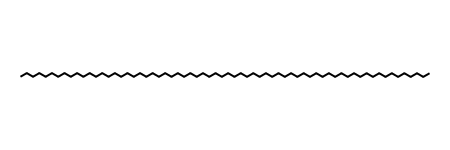

2023-06-30 19:11:20.698 [INFO    :        building:line 61 ] - Building linear polymer chain with 11 monomers (200 atoms)




polyethylmethacrylate
10 200 True True
[#6:1](-[#6:2](-*)(-[#6:3](-[#1:11])(-[#1:12])-[#1:13])-[#6:4](=[#8:5])-[#8:6]-[#6:7](-[#6:8](-[#1:16])(-[#1:17])-[#1:18])(-[#1:14])-[#1:15])(-[#1:9])(-*)-[#1:10]
[#1:1]-[#6:2](-[#6:3](-[#1:9])(-[#1:10])-[#1:11])(-[#6:4](=[#8:5])-[#8:6]-[#6:7](-[#6:8](-[#1:14])(-[#1:15])-[#1:16])(-[#1:12])-[#1:13])-[#6:17](-*)(-[#1:18])-[#1:19]
[#6:1](-[#6:2](-*)(-[#6:3](-[#1:12])(-[#1:13])-[#1:14])-[#6:4](=[#8:5])-[#8:6]-[#6:7](-[#6:8](-[#1:17])(-[#1:18])-[#1:19])(-[#1:15])-[#1:16])(-[#1:9])(-[#1:10])-[#1:11]


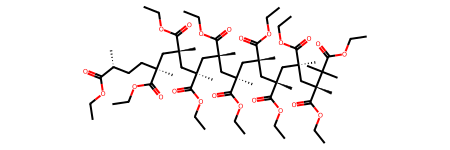



PAMAM
14 215 False False
*-[#6:1](-[#6:2](-[#6:3](-[#7:4](-[#6:6](-[#6:7](-[#7&+:8](-*)(-*)-[#1:18])(-[#1:16])-[#1:17])(-[#1:14])-[#1:15])-[#1:13])=[#8:5])(-[#1:11])-[#1:12])(-[#1:9])-[#1:10]
[#7&+:1](-[#6:2](-[#6:3](-[#7&+:4](-*)(-*)-[#1:10])(-[#1:7])-[#1:8])(-[#1:5])-[#1:6])(-*)(-*)-[#1:9]
*-[#6:1](-[#6:2](-[#6:3](-[#7:4](-[#6:6](-[#6:7](-[#7:8](-[#1:18])-[#1:19])(-[#1:16])-[#1:17])(-[#1:14])-[#1:15])-[#1:13])=[#8:5])(-[#1:11])-[#1:12])(-[#1:9])-[#1:10]
FAILED <class 'polysaccharide.polymer.exceptions.CrosslinkingError'> Linear polymer building does not support non-linear monomer input


naturalrubber


2023-06-30 19:11:20.902 [INFO    :        building:line 61 ] - Building linear polymer chain with 16 monomers (210 atoms)


15 210 True True
[#6:2](-[#6:3](=[#6:4](-[#6:5](-[#1:6])(-[#1:7])-[*:8])-[#6:9](-[#1:10])(-[#1:11])-[#1:12])-[#1:13])(-[#1:14])(-[#1:15])-[*:1]
[#6:2](-[#6:3](=[#6:4](-[#6:5](-[#1:6])(-[#1:7])-[#1:8])-[#6:9](-[#1:10])(-[#1:11])-[#1:12])-[#1:13])(-[#1:14])(-[#1:15])-[*:1]
[#6:2](-[#6:3](=[#6:4](-[#6:5](-[#1:6])(-[#1:7])-[*:8])-[#6:9](-[#1:10])(-[#1:11])-[#1:12])-[#1:13])(-[#1:14])(-[#1:15])-[#1:1]


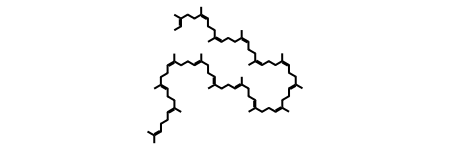



polyphenylenesulfone
15 210 True True
*-[#6:1]1=[#6:2](-[#6:3](=[#6:4](-[#16:5](=[#8:6])(=[#8:9])-*)-[#6:7](=[#6:8]-1-[#1:13])-[#1:12])-[#1:11])-[#1:10]
*-[#6:1]1=[#6:2](-[#6:3](=[#6:4](-[#16:5](=[#8:6])(=[#8:9])-[#1:14])-[#6:7](=[#6:8]-1-[#1:13])-[#1:12])-[#1:11])-[#1:10]
*-[#16:1](=[#8:2])(-[#6:3]1=[#6:4](-[#6:5](=[#6:6](-[#6:8](=[#6:7]-1-[#1:12])-[#1:13])-[#1:14])-[#1:11])-[#1:10])=[#8:9]
FAILED <class 'polysaccharide.polymer.exceptions.SubstructMatchFailedError'> 


polyvinylchloride
32 200 True True
*-[#6:1](-[#1:2])(-[#1:3])-[#6:4](-[#17:5])(-[#1:6])-*
*-[#6:1](-[#6:2](-[#17:3])(-[#1:4])-[#1:7])(-[#1:5])-[#1:6]
[#6:1](-*)(-[#1:2])(-[#17:3])-[#6:4](-[#1:5])(-[#1:6])-[#1:7]


2023-06-30 19:11:21.084 [INFO    :        building:line 61 ] - Building linear polymer chain with 33 monomers (200 atoms)


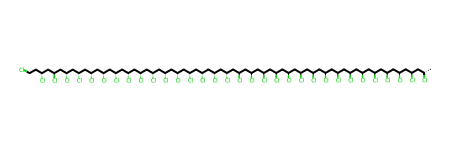



atactic_styrene
12 210 True True
[#6:2](-[#6:3](-[#1:4])(-[#1:5])-[*:6])(-[#6:7]1-[#6:8](=[#6:9](-[#6:10](=[#6:11](-[#6:12]=1-[#1:13])-[#1:14])-[#1:15])-[#1:16])-[#1:17])(-[#1:18])-[*:1]
[#6:2](-[#6:3](-[#1:4])(-[#1:5])-[#1:6])(-[#6:7]1-[#6:8](=[#6:9](-[#6:10](=[#6:11](-[#6:12]=1-[#1:13])-[#1:14])-[#1:15])-[#1:16])-[#1:17])(-[#1:18])-[*:1]
[#6:2](-[#6:3](-[#1:4])(-[#1:5])-[*:6])(-[#6:7]1-[#6:8](=[#6:9](-[#6:10](=[#6:11](-[#6:12]=1-[#1:13])-[#1:14])-[#1:15])-[#1:16])-[#1:17])(-[#1:18])-[#1:1]
FAILED <class 'polysaccharide.polymer.exceptions.SubstructMatchFailedError'> 


syntactic_styrene
12 210 True True
*-[#6:1](-[#6:2](-[#1:10])(-[#1:11])-*)(-[#6:3]1=[#6:4](-[#6:8](=[#6:7](-[#6:6](=[#6:5]-1-[#1:13])-[#1:14])-[#1:15])-[#1:16])-[#1:12])-[#1:9]
*-[#6:1](-[#6:2](-[#1:10])(-[#1:11])-[#1:12])(-[#6:3]1=[#6:4](-[#6:8](=[#6:7](-[#6:6](=[#6:5]-1-[#1:14])-[#1:15])-[#1:16])-[#1:17])-[#1:13])-[#1:9]
[#6:1](-*)(-[#1:2])(-[#1:3])-[#6:4](-[#6:5]1=[#6:6](-[#6:10](=[#6:9](-[#6:8](=[#6:7]-1-[#1:13])-

2023-06-30 19:11:21.638 [INFO    :        building:line 61 ] - Building linear polymer chain with 20 monomers (202 atoms)


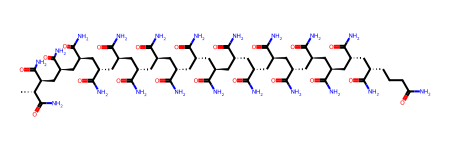

2023-06-30 19:11:21.824 [INFO    :        building:line 61 ] - Building linear polymer chain with 11 monomers (211 atoms)




pnipam_modified
10 211 True True
[C:2](-[#1:3])(-[#1:4])(-[C:5](-[#1:6])(-[C:7](=[O:8])-[N:9](-[#1:10])-[C:11](-[#1:12])(-[C:13](-[#1:14])(-[#1:15])-[#1:16])-[C:17](-[#1:18])(-[#1:19])-[#1:20])-[*:21])-[*:1]
[C:2](-[#1:3])(-[#1:4])(-[C:5](-[#1:6])(-[C:7](=[O:8])-[N:9](-[#1:10])-[C:11](-[#1:12])(-[C:13](-[#1:14])(-[#1:15])-[#1:16])-[C:17](-[#1:18])(-[#1:19])-[#1:20])-[#1:21])-[*:1]
[C:2](-[#1:3])(-[#1:4])(-[C:5](-[#1:6])(-[C:7](=[O:8])-[N:9](-[#1:10])-[C:11](-[#1:12])(-[C:13](-[#1:14])(-[#1:15])-[#1:16])-[C:17](-[#1:18])(-[#1:19])-[#1:20])-[*:21])-[#1:1]


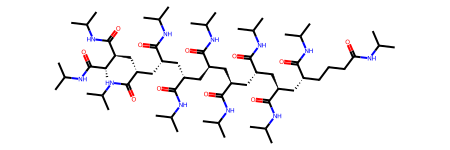



peg_modified


2023-06-30 19:11:22.036 [INFO    :        building:line 61 ] - Building linear polymer chain with 28 monomers (205 atoms)


27 205 True False
[#6:5](-[#1:6])(-[#1:7])(-[#6:8](-[#1:9])(-[#1:10])-[#8:11]-[*:12])-[*:4]
[#6:5](-[#1:6])(-[#1:7])(-[#6:8](-[#1:9])(-[#1:10])-[#8:11]-[C:12](-[#1:13])(-[#1:14])-[#1:15])-[*:4]
[#6:5](-[#1:6])(-[#1:7])(-[#6:8](-[#1:9])(-[#1:10])-[#8:11]-[*:12])-[#8:4]-[#6:2](-[#1:1])(-[#1:3])-[#1:16]


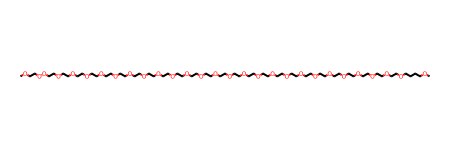

In [9]:
targ_size = 200
outpath = Path('long_homopolymers')

for mol_name, polymer in polymers.items():
    print(polymer.mol_name)
    smarts = polymer.monomer_info.SMARTS

    try:
        thresh_DOP = monomer.estimate_max_DOP(smarts, max_chain_len=targ_size)
        N = monomer.estimate_chain_len(smarts, DOP=thresh_DOP + 1)
        print(thresh_DOP, N, monomer.is_linear(smarts), monomer.is_homopolymer(smarts))
        for sm in smarts.values():
            print(sm)

        new_poly = building.build_linear_polymer(polymer.monomer_info.SMARTS, DOP=thresh_DOP + 1, add_Hs=False)
        smiles = new_poly.to_smiles()
        display(Chem.MolFromSmiles(smiles))
    except Exception as e:
        print('FAILED', type(e), e)
    print('\n')


In [ ]:
pdir = mgr.polymers['polymethylketone']
for resname, SMARTS in pdir.monomer_info.SMARTS.items():
    display(Chem.MolFromSmarts(SMARTS))

In [ ]:
dir(building)

## Analyzing replicates for Polymers paper

In [ ]:
mgr_equil = PolymerManager(COLL_PATH / 'water_soluble_polymers_equil')
for mol_name, polymer in mgr_equil.filtered_by(is_solvated).items():
    print(mol_name, len(polymer.completed_sims))

In [ ]:
rdf_dframe = pd.read_csv(sim_paths.spatial_data)
radii, rdfs = analysis.trajectory.rdfs_to_plot_data(rdf_dframe)
fig, ax = plotutils.plot_df_props(radii, rdfs)

In [ ]:
prop_dframe = pd.read_csv(sim_paths.time_data)
times, props = analysis.trajectory.props_to_plot_data(prop_dframe)
fig, ax = plotutils.plot_df_props(times, props)

In [ ]:
mgr_confs = PolymerManager(COLL_PATH / 'water_soluble_polymers_confs')
mol_name = 'paam_modified_conf_1_solv_water'

pdir = mgr_confs.polymers[mol_name]
sim_dir = mgr_confs.all_completed_sims[mol_name][0]
sim_paths, sim_params = pdir.load_sim_paths_and_params(sim_dir)

## Running component scripts commands

In [ ]:
# Source collection / structure directory
strct_name = 'simple_polymers'
# strct_name = 'water_soluble_polymers_confs'
# strct_name = 'water_soluble_polymers_equil'

COLL_PATH = Path('Collections')
COMPAT_PDB_PATH = Path('compatible_pdbs_updated')

pdb_path  = COMPAT_PDB_PATH / strct_name / f'{strct_name}_structures'
mono_path = COMPAT_PDB_PATH / strct_name / f'{strct_name}_monomers'
src_path   = COLL_PATH / strct_name

pdb_str = str(pdb_path)
mono_str = str(mono_path)
src_str = str(src_path)

# Defining control arguments
setup_kwargs = {
    'reset' : False,
    'purge_sims' : False,
    'purge_logs' : False
}
solvate = not True

# Solvent parameters
desired_solvents = ('WATER_TIP3P',) # (None,)
solv_template    = 'solv_polymer_template_box.inp'
exclusion = 1.0*nanometer

# Parsing args for bash digest
arg_str = ' '.join(f'--{arg_name}'
    for arg_name, should_apply in setup_kwargs.items()
        if should_apply
)
solv_str = ' '.join(desired_solvents)

In [ ]:
# Setup, and optionally solvate
%run -i 'setup_collection.py' -out $src_str -pdb $pdb_str -mono $mono_str $arg_str
if solvate:
    %run -i 'polymer_master.py' -src=$src_str 'solvate' -s=$solv_str -pt=$solv_template -e=$exclusion._value --molecules 'polyvinylchloride' 'polythiophene' 'naturalrubber'

In [ ]:
# Charge, simulate, and analyze select trajectories
mgr = PolymerManager(COLL_PATH / 'simple_polymers')
targ_mols = ['polyvinylchloride']#, 'naturalrubber']
mol_str = ' '.join(targ_mols)

%run -i 'polymer_master.py' -src=$src_str 'charge' -cp='standard_chg_params' --molecules $mol_str --solvent
%run -i 'polymer_master.py' -src=$src_str 'simulate' -sp 'equilibration' --molecules $mol_str --solvent
# %run -i 'polymer_master.py' -src=$src_str 'simulate' -sp 'debug_sim_NPT' --molecules $mol_str --solvent
%run -i 'polymer_master.py' -src=$src_str 'analyze' --molecules $mol_str --solvent

## Investigating water underspecifiacition after equilibration

In [ ]:
mgr = PolymerManager(COLL_PATH / 'water_soluble_polymers_confs')
pdir = mgr.polymers['peg_modified_conf_1_solv_water']

In [ ]:
import MDAnalysis as mda
from polysaccharide.molutils.pdb import pdb_water_atoms_to_hetatoms

pdb_dir = Path('trans_pdb')
pdb_dir.mkdir(exist_ok=True)

traj = pdir.load_traj(remove_solvent=False)
conf = traj[-1]
conf.save_pdb(pdb_dir / 'mdt_struct.pdb')
pdb_water_atoms_to_hetatoms(pdb_dir / 'mdt_struct.pdb', output_path=pdb_dir / 'mdt_struct_het.pdb')

sim_paths, sim_params = pdir.load_sim_paths_and_params()
u = mda.Universe(pdir.structure_file, sim_paths.trajectory)

u.trajectory[-1]
poly_box = u.select_atoms('all')
poly_box.write(pdb_dir / 'mda_struct.pdb')
pdb_water_atoms_to_hetatoms(pdb_dir / 'mda_struct.pdb', output_path=pdb_dir / 'mda_struct_het.pdb')

In [ ]:
from openff.toolkit.topology.topology import UnmatchedAtomsError

tops = {}
pdb_paths = [Path(i) for i in ('mdt_struct.pdb', 'mdt_struct_het.pdb','mda_struct.pdb', 'mda_struct_het.pdb')]

for pdb_path in pdb_paths:
    try:
        tops[pdb_path.stem] = Topology.from_pdb_and_monomer_info(str(pdb_path), monomer_info_json=pdir.monomer_file_uncharged)
    except UnmatchedAtomsError:
        print(f'{pdb_path.stem} failed')

In [ ]:
mgr = PolymerManager(COLL_PATH / 'water_soluble_polymers_equil')
pdir = mgr.polymers['pnipam_modified_conf_1_solv_water_equil']
pdir.offmol_matched()

In [ ]:
top, *_ = Topology.from_pdb_and_monomer_info(str(pdb), monomer_info_json=pdir.monomer_file_uncharged, strict=False)

defective = [
    mol for mol in top.molecules
        if not all(atom.metadata['already_matched'] for atom in mol.atoms)
]
len(defective)

In [ ]:
from polysaccharide import OPENFF_DIR

In [ ]:
sim_params = SimulationParameters.from_file(impres.files(resources.sim_templates) / 'equilibration.json')
sim_params.forcefield_path

In [ ]:
copyfile(sim_params.forcefield_path, sim_params.forcefield_path.stem)

In [ ]:
# pdb = pdir.structure_file
pdb = Path('pni.pdb')

rdmol = Chem.MolFromPDBFile(str(pdb), removeHs=False)
frags = Chem.GetMolFrags(rdmol, asMols=True)

for frag in frags[:10]:
    # if frag.GetNumAtoms() == 2:
    display(frag)

In [ ]:
for atom in frags[1].GetAtoms():
    pdb_info = atom.GetPDBResidueInfo()
    print(pdb_info.GetOccupancy())

In [ ]:
topo = pdir.off_topology_matched(strict=False)

defective = []
for mol in topo.molecules:
    if not all(atom.metadata['already_matched'] for atom in mol.atoms):
        defective.append(mol)
len(defective)

## Testing Process workflow

In [ ]:
from polysaccharide.workflow import components as wcomponents
from polysaccharide.workflow.process import Process

chg_params = ChargingParameters.from_file(impres.files(resources.chg_templates) / 'standard_chg_params.json')
sim_params = SimulationParameters.from_file(impres.files(resources.sim_templates) / 'debug_sim_NPT.json')
inp_template = impres.files(resources.inp_templates) / 'solv_polymer_template_box.inp'

proc = Process(
    components=[
        wcomponents.Solvate(solvents=WATER_TIP3P, exclusion=1*nanometer, template_path=inp_template),
        wcomponents.ChargeAssignment(chg_params=chg_params),
        wcomponents.RunSimulations(sim_params=sim_params)
    ],
    proc_name='sim_test'
)
proc, proc.tag

In [ ]:
pdir = mgr.polymers['polyvinylchloride']
logger = logging.getLogger('test')

proc.collated_polymer_fn(pdir, logger)

## Removing fields from XML (useful for annoying barostate in OpenMM states

In [ ]:
import xml.etree.ElementTree as ET

for sim_dir, sim_paths_file in pdir.simulation_paths.items():
    sim_paths = SimulationPaths.from_file(sim_paths_file)
    chk = sim_paths.checkpoint
    if chk.suffix == '.xml':
        tree = ET.parse(sim_paths.checkpoint)
        root = tree.getroot()

        par = next(root.iter('Parameters'))
        par.clear()

## Testing dynamic checkpoint file updating

In [ ]:
import pickle

class Test:
    def __init__(self, val : int, checkpoint : Path) -> None:
        self.val = val
        self.checkpoint_path = checkpoint

    def to_file(self):
        if hasattr(self, 'checkpoint_path'):
            with self.checkpoint_path.open('wb') as file:
                pickle.dump(self, file)

    def __setattr__(self, __name: str, __value: Any) -> None:
        super().__setattr__(__name, __value)
        self.to_file()
        print(__name, __value)

In [ ]:
p = Path('test.pkl')
p.touch()

t = Test(5, p)
t.other = 'word'

In [ ]:
with p.open('rb') as file:
    v = pickle.load(file)

v.__dict__
v.foo = 'bar'

## Experimenting with grid size optimization WRT aspect and number of squares

In [ ]:
from math import ceil, sqrt, floor

def size_penalty(N_targ : int, N_real : int) -> float:
    return (N_real / N_targ - 1)**2

def aspect_penalty(a_targ : float, a_real : float) -> float:
    # return (a_real / a_targ - 1)**2
    return 1 - min(a_targ / a_real, a_real / a_targ)

def dims(N : int, a : float=1/1, w1=1, w2=1) -> tuple[int, int]:
    '''Given a particular number of cells and an aspect ratio, yields the smallest 2x2 grid dimensions which accomodate at least N grid squares whose aspect ratio is closest to the '''
    return min( 
        ((r, ceil(N / r))
            for r in range(1, N + 1)
        ),
        key=lambda dims : w1*size_penalty(N, dims[0]*dims[1]) + w2*aspect_penalty(a, dims[0]/dims[1])
    )

a = 2/1
for N in range(1, 20):
    nrows, ncols = dims(N, a)
    fig, ax = plotutils.presize_subplots(nrows=nrows, ncols=ncols, scale=1)
    fig.suptitle(f'N = {N}')

## Testing PyMBAR timeseries equilibration detection

In [ ]:
from pymbar import timeseries
from polysaccharide.analysis.equilibrium import EQUIL_DETECTOR_REGISTRY
equil_det = EQUIL_DETECTOR_REGISTRY['PyMBAREquilDetector']
# equil_det = EQUIL_DETECTOR_REGISTRY['BinSegEquilDetector']

fast = True

outdir = Path('figures_for_paper/pymbar_equil')
outdir.mkdir(exist_ok=True)

for mol_name, pdir in mgr.filtered_by(is_solvated).items():
    mol_dir = outdir/mol_name
    mol_dir.mkdir(exist_ok=True)

    sim_paths, sim_params = pdir.load_sim_paths_and_params()
    time_df = pd.read_csv(sim_paths.time_data)
    times, time_data = trajectory.props_to_plot_data(time_df)
    times_arr = times.to_numpy()[:, 0]

    fig, ax = plotutils.plot_df_props(times, time_data, df_label='Original samples', elongation=1/2, scale=25)
    for axes, (label, prop_data) in zip(ax.flatten(), time_data.items()):
        prop_data = prop_data.to_numpy()
        t = equil_det.equil_loc(prop_data)
        uncorr_idxs = timeseries.subsample_correlated_data(prop_data, fast=fast)
        t_equil = times_arr[t]

        axes.plot(times_arr[uncorr_idxs], prop_data[uncorr_idxs], label='Uncorrelated samples')
        axes.axvline(t_equil, color='r')
        axes.legend()

    # fig.savefig(mol_dir/f'pymbar_props_{mol_name}.png', bbox_inches='tight')
    # plt.close()

In [ ]:
pdir = mgr.polymers['peg_modified_solv_water']

sim_paths, sim_params = pdir.load_sim_paths_and_params()
state_df = pd.read_csv(sim_paths.state_data)

exclude = ('#"Step"', 'Elapsed Time (s)', 'Speed (ns/day)')
state_df = state_df[[label for label in state_df.columns if label not in exclude]]
state_time, state_data = trajectory.props_to_plot_data(state_df)

fig, ax = plotutils.plot_df_props(state_time, state_data, df_label='test', nrows=2, ncols=3, scale=20)
for axes in ax.flatten():
    axes.legend()

## Plotting disparities in charges

In [ ]:
num_bins = 30
order = ['ABE10_exact', 'ABE10_averaged', 'Espaloma_AM1BCC']
outdir = Path('figures_for_paper') / f'Charge diagrams - {mgr.collection_dir.stem}'
outdir.mkdir(exist_ok=True)

for mol_name, polymer in mgr.filtered_by((is_unsolvated, is_charged)).items():
    savedir = outdir / mol_name
    savedir.mkdir(exist_ok=True)

    # single charges
    for charge_method in polymer.charges: 
        polymer.assign_charges_by_lookup(charge_method)
        fig, ax = molutils.rdmol.rdkdraw.rdmol_prop_heatmap_colorscaled(
            polymer.offmol.to_rdkit(),
            prop='PartialCharge',
            annotate=True,
            cmap=plt.get_cmap('viridis'),
            cbar_label=f'q (elem. charge) ({charge_method} only)'
        )
        fig.savefig(savedir/f'{mol_name} charges - {charge_method}', bbox_inches='tight')
        plt.close()

    # charge pairs
    for (chg_method_1, chg_method_2) in combinations(sorted(polymer.charges.keys(), key=lambda x : order.index(x)), 2):
        chg_str = f'{chg_method_1} vs {chg_method_2}'
        chgs_ref  = polymer.charges[chg_method_1]._magnitude
        chgs_comp = polymer.charges[chg_method_2]._magnitude
        diff = chgs_ref - chgs_comp
        chg_RMSE = round(analysis.statistics.RMSE(chgs_ref, chgs_comp), 4)

        fig, ax = polymer.compare_charges(chg_method_1, chg_method_2, annotate=True, converter='CXSMARTS')
        fig.savefig(savedir/f'{mol_name} charge comparison - {chg_str}', bbox_inches='tight')
        plt.close()

        # pair histograms
        plt.hist(diff, bins=np.linspace(diff.min(), diff.max(), num_bins))
        plt.xlabel(f'{general.GREEK_UPPER["delta"]}q (elem. charge): {chg_str}')
        plt.ylabel('Number of atoms')
        plt.legend([f'RMSE = {chg_RMSE} e'], loc='best')
        plt.savefig(savedir/f'{mol_name} histogram - {chg_str}', bbox_inches='tight')
        plt.close()

## Testing Polymer building and from-monomer calculations

In [ ]:
for pdir in mgr.polymers_list:
    if pdir.has_monomer_info:
        mono = pdir.monomer_info.monomers
        print(pdir.mol_name, monomer.count_middle_and_term_mono(mono), '\n\tLinear : ', monomer.is_linear(mono), '\n\tHomo : ', monomer.is_homopolymer(mono))

In [ ]:
from collections import defaultdict

solvent = None
DOP_min, DOP_max = 3, 10

# testing that chain length errors (if any) are independent of DOP
res = []
logs = defaultdict(list)
for i, polymer in enumerate(mgr.polymers_list):
    if polymer.solvent == solvent:
        print(polymer.mol_name)
        try:
            mono_structs = polymer.monomer_info.monomers
            if polymer.mol_name == 'paam_modified':
                mono_structs.pop('paam_SPECIAL_TERM')

            print(f'{len(mono_structs)} monomers in chain')

            dop_errors = []
            for DOP in range(DOP_min, DOP_max):
                n_atoms_pred = monomer.estimate_chain_len(mono_structs, DOP=DOP)
                chain = building.build_linear_polymer(mono_structs, DOP=DOP, add_Hs=False)
                n_atoms_real = chain.n_particles
                print(n_atoms_real, n_atoms_pred)
                dop_errors.append(n_atoms_real - n_atoms_pred)
            res.append(dop_errors)
            logs['Success'].append(polymer.mol_name)

        except Exception as e:
            print(e)
            logs[type(e).__name__].append(polymer.mol_name)

res = np.array(res)            
plt.imshow(res)

In [ ]:
# demonstrating RDKit aromaticity substructure mismatch for even simple ringed molecules (e.g. benzene)
rdkdraw.set_rdkdraw_size(300, 2/1)
smiles_mol = Chem.MolFromSmiles('C1-C=C-C=C-C=1')
# smiles_mol = Chem.AddHs(smiles_mol)
Chem.MolToSmarts(smiles_mol)

smarts_mol = Chem.MolFromSmarts('[#6]1-[#6]=[#6]-[#6]=[#6]-[#6]=1')
# smarts_mol = Chem.AddHs(smarts_mol)
display(smiles_mol)
display(smarts_mol)
smarts_mol.GetSubstructMatch(smiles_mol)

## Comparing converters for heatmapping drawing

In [ ]:
cmap = plt.get_cmap('turbo')
# pdir = mgr.polymers['polythiophene_solv_water']
pdir = mgr.polymers['polyethylmethacrylate_solv_water']

dim = 10
aspect = 4/1
annotate = False

for cvtr_type in ('InChI', 'SMARTS', 'CXSMARTS'):
    fig, ax = pdir.compare_charges('ABE10_exact', 'Espaloma_AM1BCC', cmap, annotate=annotate, precision=5, converter=cvtr_type)
    fig.set_size_inches(dim, dim * aspect)

In [ ]:
from rdkit.Chem.Draw import SimilarityMaps

cvtr = 'InChI'

offmol1 = pdir.charged_offmol_from_sdf('ABE10_exact')
rdmol1 = offmol1.to_rdkit()
flatmol1 = rdconvert.flattened_rdmol(rdmol1, converter=cvtr)

offmol2 = pdir.charged_offmol_from_sdf('Espaloma_AM1BCC')
rdmol2 = offmol2.to_rdkit()
flatmol2 = rdconvert.flattened_rdmol(rdmol2, converter=cvtr)

diff = rdcompare.difference_rdmol(flatmol1, flatmol2, prop='PartialCharge', remove_map_nums=True)
deltas = [diff.GetAtomWithIdx(i).GetDoubleProp('DeltaPartialCharge') for i in range(diff.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(diff, deltas, colorMap='jet', contourLines=10, alpha=0.3)
plt.savefig('test.png')

In [ ]:
# PIL.Image.frombytes('RGBA', fig.canvas.get_width_height(), fig.canvas.tostring_argb())

n = 250
img = PIL.Image.frombytes('RGB', (n, n), fig.canvas.tostring_rgb())
display(img)

In [ ]:
pdir = mgr.polymers['polyvinylchloride_solv_water']

fig1, ax1 = pdir.compare_charges('ABE10_exact', 'Espaloma_AM1BCC', cmap=plt.get_cmap('turbo'), converter='InChI')
fig2, ax2 = pdir.compare_charges('ABE10_exact', 'Espaloma_AM1BCC', cmap=plt.get_cmap('turbo'), converter='SMARTS')

ax1.set_title(pdir.mol_name)
ax2.set_title(pdir.mol_name)

## Generating monomer files for polyamides

In [ ]:
POLYAM_PATH   = Path('compatible_pdbs/polyamides')
p = POLYAM_PATH/'smiles.json'

with p.open('r') as smiles_file:
    mono_smiles = json.load(smiles_file)
mono_smiles['TMC'] = mono_smiles['TMC'].replace('Cl', 'O[H]') # replace chlorides with oxygens present in full polymer

rdkdraw.set_rddraw_size(400, 3/2)

mono_mols, mono_smarts = {}, {}
for name, SMILES in mono_smiles.items():
    rdmol = Chem.MolFromSmiles(SMILES, sanitize=False)
    for atom in rdmol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx() + 1)
    
    mono_mols[name] = rdmol
    mono_smarts[name] = Chem.MolToSmarts(rdmol)

    display(rdmol)


In [ ]:
monomers = {
    'MPD_monovalent' : '[H:1]-[#6:2]1:[#6:3](-[H:4]):[#6:5](-[#7:6](-*)-[H:8]):[#6:9](-[H:10]):[#6:11](-[#7:12](-[H:13])-[H:14]):[#6:15]:1-[H:16]',
    'MPD_bivalent'   : '[H:1]-[#6:2]1:[#6:3](-[H:4]):[#6:5](-[#7:6](-*)-[H:8]):[#6:9](-[H:10]):[#6:11](-[#7:12](-[H:13])-*):[#6:15]:1-[H:16]',
    'TMC_monovalent' : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-[#8:13]-[H:14]):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-[#8:20]-[H:21]', 
    'TMC_bivalent'   : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-*):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-[#8:20]-[H:21]', 
    'TMC_trivalent'  : '[H:1]-[#6:2]1:[#6:3](-[#6:4](=[#8:5])-*):[#6:8](-[H:9]):[#6:10](-[#6:11](=[#8:12])-*):[#6:15](-[H:16]):[#6:17]:1-[#6:18](=[#8:19])-*', 
}

json_spec = {
    'monomers' : monomers,
    'caps' : {name : [] for name in monomers}
}

pam_mono_path = POLYAM_PATH/'polyamides.json'
with pam_mono_path.open('w') as mono_out:
    json.dump(json_spec, mono_out, indent=4)

for pam_path in POLYAM_PATH.glob('*.pdb'):
    ind_mono_path = POLYAM_PATH/f'{pam_path.stem}.json'
    with ind_mono_path.open('w') as mono_out:
        json.dump(json_spec, mono_out, indent=4)

In [ ]:
pam_pdbs = [path for path in POLYAM_PATH.glob('*.pdb')]

In [ ]:
pdb_file = pam_pdbs[1]

openff_topology, _, _error = Topology.from_pdb_and_monomer_info(str(pdb_file), pam_mono_path, strict=False, verbose=False)
mol = next(openff_topology.molecules)

for atom in mol.atoms:
    if not atom.metadata['already_matched']:
        print(atom.metadata)

rdkdraw.set_rddraw_size(500, 3/2)
display(mono_mols[pdb_file.stem])

## Some other section